# 2. Tensorflow Prophet Testing

## I - Setup

In [1]:
# Import of librairies
import tensorflow as tf
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
# Creating smaller dataset

In [6]:
df = df_full['nb_free_docks']
df.index = df_full['date_of_update']
df.head()

date_of_update
2020-05-05 00:01:00    20
2020-05-05 00:02:00    20
2020-05-05 00:03:00    20
2020-05-05 00:04:00    20
2020-05-05 00:05:00    20
Name: nb_free_docks, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ab463910>],
      dtype=object)

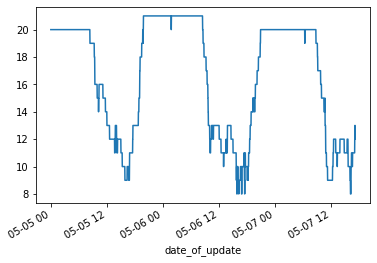

In [7]:
# Graphic visualisation
df.plot(subplots=True)

In [8]:
# Setting the train_split value for later use (around 70%)
TRAIN_SPLIT = 2500
tf.random.set_seed(13)

In [9]:
df = df.values

In [10]:
# Standardization
df_mean = df[:TRAIN_SPLIT].mean()
df_std = df[:TRAIN_SPLIT].std()
df = (df-df_mean)/df_std

In [11]:
def reverse_transformer(x):
    return np.round(x * df_std + df_mean)

We intend to use the last 60 recorded temperature observations to predict the temperature at 60 next step

In [12]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [13]:
past_history = 120
future_target = 60
STEP = 1

x_train, y_train = multivariate_data(df, df[1:], 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target, STEP)
x_val, y_val = multivariate_data(df, df[1:], TRAIN_SPLIT, None,
                                       past_history,
                                       future_target, STEP)

In [14]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

In [15]:
print ('Single window of past history')
print (x_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.73274271]
 [0.

In [16]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [17]:
print ('Single window of past history')
print (x_train.shape)
print ('\n Target temperature to predict')

Single window of past history
(2380, 120, 1)

 Target temperature to predict


In [18]:
for x, y in  train_data.take(1):
    print(x[0].shape)
    print(y[0].shape)

(120, 1)
(60,)


In [19]:
train_data

<RepeatDataset shapes: ((None, 120, 1), (None, 60)), types: (tf.float64, tf.float64)>

In [20]:
for x, y in  train_data.take(1):
    print(x.shape)
    print(y.shape)

(32, 120, 1)
(32, 60)


In [21]:
train_data

<RepeatDataset shapes: ((None, 120, 1), (None, 60)), types: (tf.float64, tf.float64)>

In [22]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(60)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [23]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 60)                540       
Total params: 860
Trainable params: 860
Non-trainable params: 0
_________________________________________________________________


In [24]:
for x, y in val_data.take(3):
    print(x.shape)
    print(y.shape)
    print(simple_lstm_model.predict(x).shape)

(32, 120, 1)
(32, 60)
(32, 60)
(32, 120, 1)
(32, 60)
(32, 60)
(32, 120, 1)
(32, 60)
(32, 60)


In [25]:
EPOCHS = 10
EVALUATION_INTERVAL = 200

In [26]:
simple_lstm_model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=200)


Train for 200 steps, validate for 200 steps
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6175 - val_loss: 0.2459
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1975 - val_loss: 0.1599
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1502 - val_loss: 0.1532
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1463 - val_loss: 0.1496
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1447 - val_loss: 0.1467
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1432 - val_loss: 0.1440
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1422 - val_loss: 0.1402
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1371 - val_loss: 0.1407
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1345 - val_loss: 0.1395
Epoch 10/10
200/200 [==========================

In [27]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

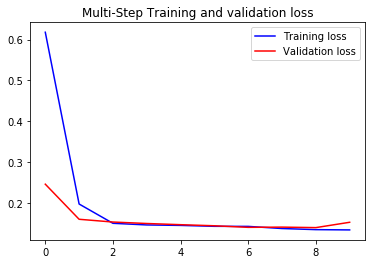

In [28]:
plot_train_history(simple_lstm_model_history, 'Multi-Step Training and validation loss')

In [29]:
def create_time_steps(length):
  return list(range(-length, 0))

In [30]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.plot(num_in, reverse_transformer(np.array(history)), label='History')
  plt.plot(np.arange(num_out)/STEP, reverse_transformer(np.array(true_future)), 
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, reverse_transformer(np.array(prediction)), 
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

## III . Results

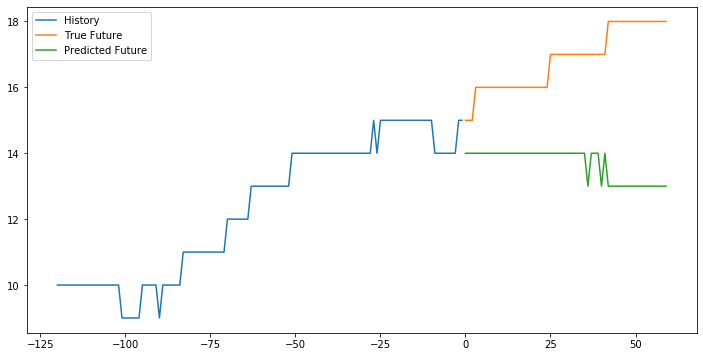

In [31]:
for x, y in val_data.take(1):
    multi_step_plot(x[0], y[0], simple_lstm_model.predict(x)[0])